In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
from imp import reload
from typing import List
import os
import pickle
import pandas as pd
import numpy as np

from skimage.transform import resize

from data_utils import DataHandler
import evaluate
import text_retrieval
import image_features
import image_utils
import bg_masks
import similarities
import detect_textbox
import histogram_processing
import visualizer

N_PROCESS = 10

/var/folders/zj/hvgbgg5j4qdc72qhxpzc2x2h0000gn/T/ipykernel_8349/894277302.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
data_handler = DataHandler()

# Load images:
db, db_files = data_handler.load_images(
    folder="../data/BBDD/", extension=".jpg", desc="Loading BBDD Data...")
qsd1_w5, qsd1_w5_files = data_handler.load_images(
    folder="../data/qsd1_w5_denoised/", extension=".jpg", desc="Loading qsd1_w5 Data...")

# Load text:
db_text = data_handler.load_text(
    folder="../data/BBDD/", extension=".txt", desc="Loading BBDD Text data...")
qsd1_w5_text = data_handler.load_text_multiple(
    folder="../data/qsd1_w5_denoised/", extension=".txt", desc="Loading qsd1_w5 Text data...")


Initialized DataHandler with 2 processes


Loading BBDD Data...:  28%|██▊       | 81/287 [00:02<00:03, 56.92it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Loading BBDD Data...: 100%|██████████| 287/287 [00:06<00:00, 45.41it/s]


../data/BBDD/ read: 287 images


Loading qsd1_w5 Data...: 100%|██████████| 30/30 [00:00<00:00, 116.45it/s]


../data/qsd1_w5_denoised/ read: 30 images


Loading BBDD Text data...: 100%|██████████| 287/287 [00:00<00:00, 41588.02it/s]


../data/BBDD/ read: 287 images


Loading qsd1_w5 Text data...: 100%|██████████| 30/30 [00:00<00:00, 10968.37it/s]


In [3]:
expected_results_qsd1_w5 = pickle.load(
    open('../data/qsd1_w5_denoised/gt_corresps.pkl', "rb"))

In [4]:
# get de minimum shape of the images in qsd1_w5
minimum_x = 100000
minimum_y = 100000
for idx, img in enumerate(qsd1_w5):
    if minimum_x > img.shape[0]:
        minimum_x = img.shape[0]
    if minimum_y > img.shape[1]:
        minimum_y = img.shape[1]

print("minimum_x: ", minimum_x)
print("minimum_y: ", minimum_y)

minimum_x:  515
minimum_y:  539


In [5]:
# get de minimum shape of the images in db
minimum_x = 100000
minimum_y = 100000
for idx, img in enumerate(db):
    if minimum_x > img.shape[0]:
        minimum_x = img.shape[0]
    if minimum_y > img.shape[1]:
        minimum_y = img.shape[1]

print("minimum_x: ", minimum_x)
print("minimum_y: ", minimum_y)

minimum_x:  242
minimum_y:  235


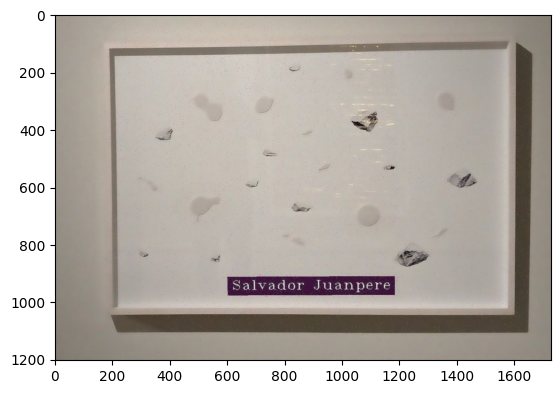

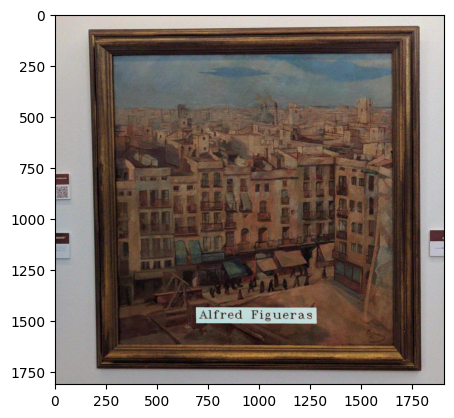

In [6]:
from skimage.filters import unsharp_mask
from skimage.exposure import equalize_hist
from skimage.exposure import adjust_gamma, equalize_adapthist
import cv2
from skimage.filters import median
from skimage.morphology import disk


# qsd1_w5 = [adjust_gamma(img, gamma=2, gain=0.6) for img in qsd1_w5]
plt.imshow(qsd1_w5[26],)
plt.show()
plt.imshow(qsd1_w5[29],)
plt.show()

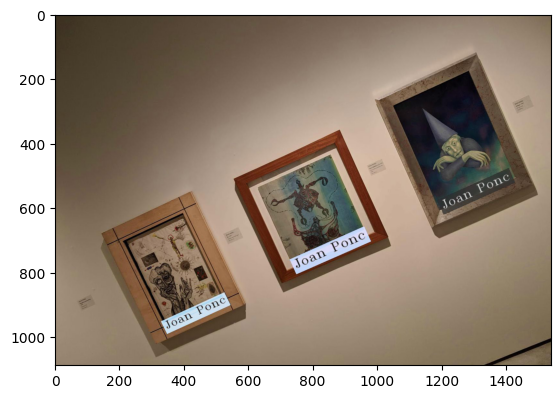

In [7]:
plt.imshow(qsd1_w5[25])

### Generate masks (try new methods)

In [8]:
reload(bg_masks)
res = bg_masks.generate_masks_multiple(
    qsd1_w5,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with up to three components...",
    image_files=qsd1_w5_files,
    output_dir='../data/morphology_masks_qsd1_w5/',
    method='mask_multiple_n',    # new morphology method
)

Generating masks with up to three components...:  67%|██████▋   | 20/30 [00:01<00:00, 10.63it/s]

1 objects were found in this image.
1 objects were found in this image.
3 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.


Generating masks with up to three components...: 100%|██████████| 30/30 [00:02<00:00, 14.95it/s]

1 objects were found in this image.
3 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
2 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
3 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.


1 objects were found in this image.
3 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.
3 objects were found in this image.
3 objects were found in this image.
1 objects were found in this image.
1 objects were found in this image.


### Load saved masks

In [9]:
# load background masks
masks_gen_morphology_qsd1_w5, masks_gen_morphology_qsd1_w5_files = data_handler.load_images(
    folder=f"../data/morphology_masks_qsd1_w5/",
    extension=".png",
    desc=f"Loading background masks for QSD1-W5..."
)

Loading background masks for QSD1-W5...: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]

../data/morphology_masks_qsd1_w5/ read: 30 images


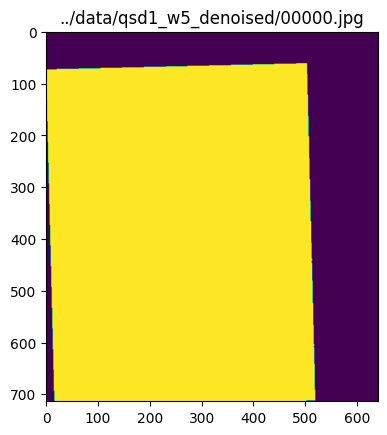

In [10]:
plt.imshow(masks_gen_morphology_qsd1_w5[4])
plt.title(qsd1_w5_files[0])
plt.show()


### Save angle and bboxes "*/frames.pkl"

In [11]:
reload(bg_masks)
results = bg_masks.get_angle_bboxes_multiple(
    masks=masks_gen_morphology_qsd1_w5,
    mssg="Computing angle and bboxes for each mask...",
    output_dir=f"../data/morphology_masks_qsd1_w5/"
)

Computing angle and bboxes for each mask...: 100%|██████████| 30/30 [00:03<00:00,  9.28it/s]

Saved results to ../data/morphology_masks_qsd1_w5/frames.pkl


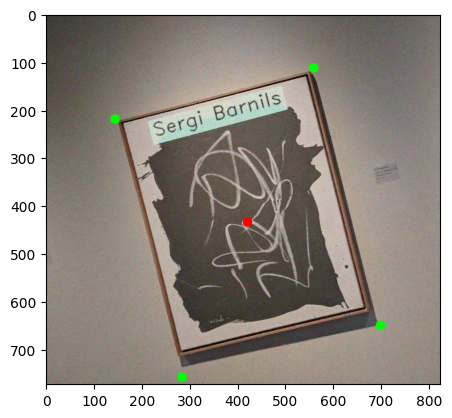

In [12]:
reload(bg_masks)
lala = bg_masks.draw_mask_points_on_image(qsd1_w5[8], masks_gen_morphology_qsd1_w5[8])
plt.imshow(lala)

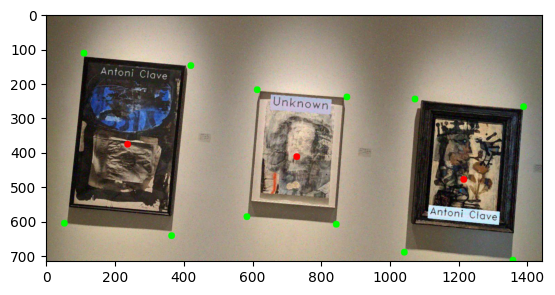

In [13]:
lala = bg_masks.draw_mask_points_on_image(qsd1_w5[10], masks_gen_morphology_qsd1_w5[10])
plt.imshow(lala)

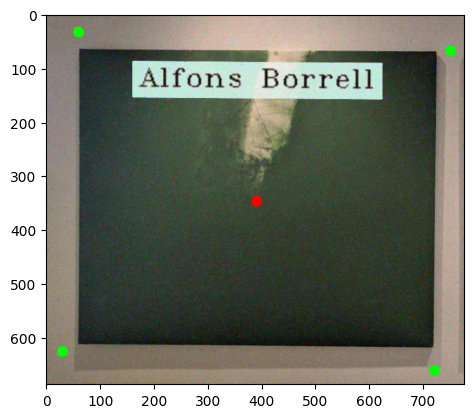

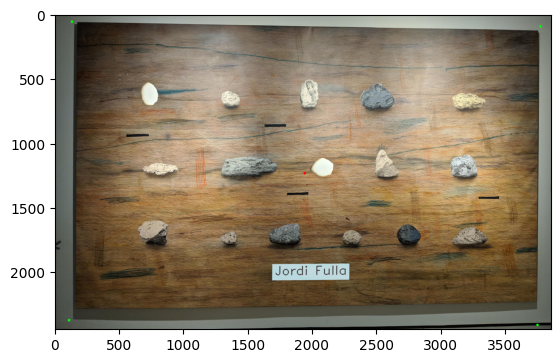

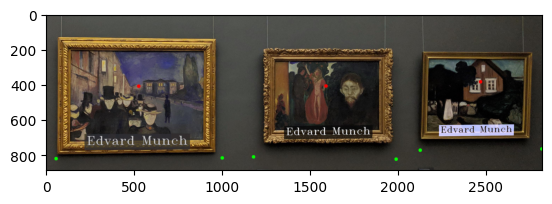

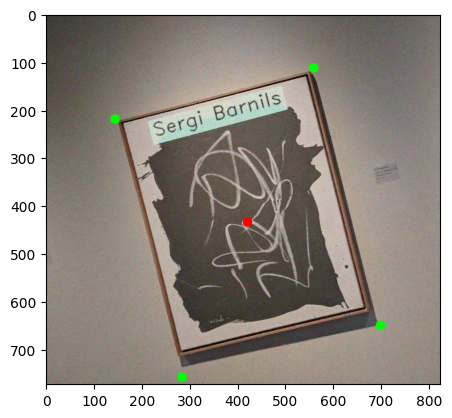

In [14]:
reload(bg_masks)
bg_masks.draw_mask_points_on_image_batch(
    # images=qsd1_w,
    # masks=masks_gen_morphology_qsd1_w5,
    n = 6,
    images=qsd1_w5[4:10],
    masks=masks_gen_morphology_qsd1_w5[4:10],
)

##### [angle, [bbox]]

In [15]:
results

[[[0.0, [(76, 95), (76, 2811), (2451, 2811), (2451, 95)]]],
 [[1.6706532713999678, [(69, 66), (83, 546), (495, 534), (481, 54)]]],
 [[0.3873146763931162, [(61, 112), (75, 2183), (1544, 2173), (1530, 102)]]],
 [[2.056279006142952, [(100, 138), (127, 890), (638, 871), (611, 119)]]],
 [[2.6025622024998065, [(0, 74), (16, 713), (532, 711), (502, 51)]]],
 [[2.8961369679329563, [(60, 33), (30, 626), (720, 661), (750, 68)]]],
 [[0.5689808330899387, [(132, 59), (109, 2375), (3746, 2412), (3769, 96)]]],
 [[0.2808594146833859, [(53, 0), (57, 820), (1002, 816), (998, 0)]],
  [0.9060620967532051, [(1193, 0), (1180, 810), (1991, 823), (2004, 1)]],
  [0.2246881796245023, [(2120, 0), (2128, 772), (2820, 765), (2817, 0)]]],
 [[14.586186068236414, [(144, 219), (284, 758), (699, 650), (559, 112)]]],
 [[0.8905362533605713, [(84, 60), (102, 1218), (1023, 1204), (1005, 46)]]],
 [[6.480466020428937, [(110, 113), (53, 606), (365, 642), (421, 149)]],
  [4.802190090054283, [(614, 219), (584, 587), (844, 609), 

### Rotate images and masks

In [16]:
reload(image_utils)
image_utils.rotate_images_and_masks_multiple(
    angle_bboxes=results,
    images=qsd1_w5,
    images_files=qsd1_w5_files,
    masks=masks_gen_morphology_qsd1_w5,
    mssg="Rotating images and masks...",
    output_dir=f"../results/rotated_qsd1_w5/"
)

Rotating images and masks...: 100%|██████████| 30/30 [00:02<00:00, 11.54it/s]

Saved images to ../results/rotated_qsd1_w5/*.jpg
Saved masks to ../results/rotated_qsd1_w5/*.png


# TASK 2

### Load rotated images and masks

In [17]:
data_handler = DataHandler()

# Load rotated images:
qsd1_w5, qsd1_w5_files = data_handler.load_images(
    folder="../results/rotated_qsd1_w5/", extension=".jpg", desc="Loading qsd1_w5 Data...")

qsd1_w5_text = data_handler.load_text_multiple(
    folder="../data/qsd1_w5_denoised/", extension=".txt", desc="Loading qsd1_w5 Text data...")

Initialized DataHandler with 2 processes


Loading qsd1_w5 Data...: 100%|██████████| 30/30 [00:00<00:00, 106.52it/s]


../results/rotated_qsd1_w5/ read: 30 images


Loading qsd1_w5 Text data...: 100%|██████████| 30/30 [00:00<00:00, 10657.16it/s]


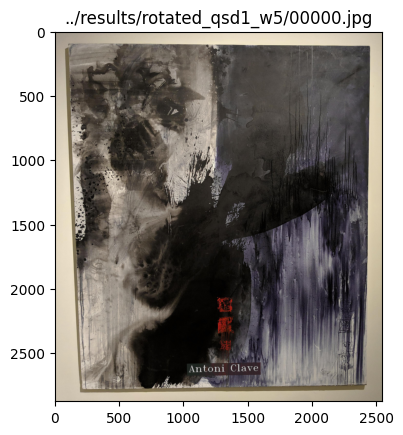

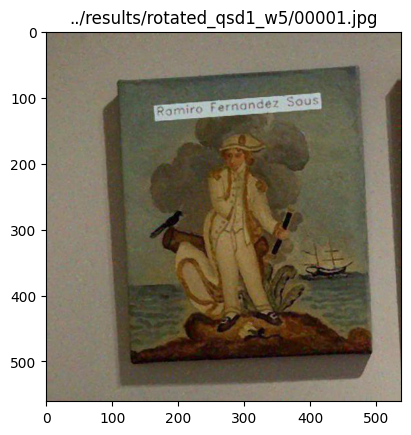

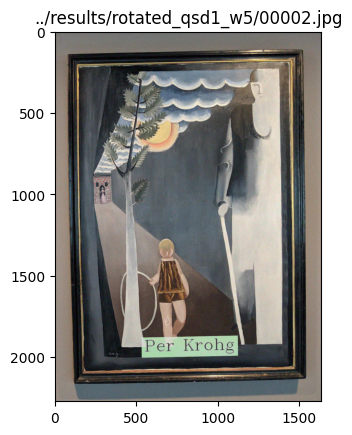

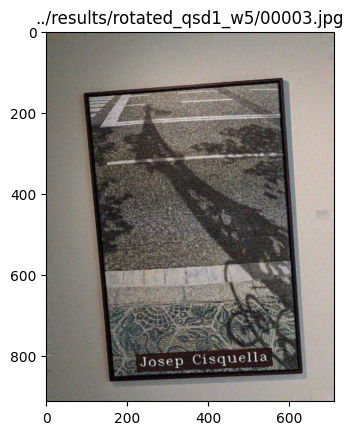

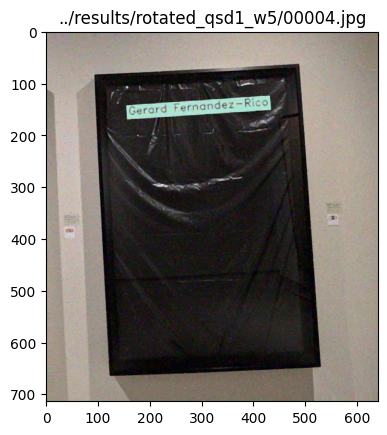

In [18]:
for i, (img, filename) in enumerate(zip(qsd1_w5, qsd1_w5_files)):
    plt.imshow(img)
    plt.title(filename)
    plt.show()
    if i > 3:
        break

## Masks

In [19]:
from skimage.filters import unsharp_mask
from skimage.exposure import equalize_hist
from skimage.exposure import adjust_gamma, equalize_adapthist
import cv2
from skimage.filters import median
from skimage.morphology import disk

"""
qsd1_w5_filt = [adjust_gamma(img, gamma=2, gain=0.6) for img in qsd1_w5]
plt.imshow(qsd1_w5_filt[26],)
plt.show()
plt.imshow(qsd1_w5_filt[29],)
plt.show()
"""

'\nqsd1_w5_filt = [adjust_gamma(img, gamma=2, gain=0.6) for img in qsd1_w5]\nplt.imshow(qsd1_w5_filt[26],)\nplt.show()\nplt.imshow(qsd1_w5_filt[29],)\nplt.show()\n'

In [20]:
# load background masks
masks_gen_rotated, masks_gen_rotated_files = data_handler.load_images(
    folder=f"../results/rotated_qsd1_w5/",
    extension=".png",
    desc=f"Loading background masks for QSD1-W5..."
)

Loading background masks for QSD1-W5...: 100%|██████████| 30/30 [00:01<00:00, 25.10it/s]


../results/rotated_qsd1_w5/ read: 30 images


In [21]:
reload(image_utils)
reload(detect_textbox)

bboxes_qsd1_w5, paintings_cropped, mask_text = image_utils.crop_paintings_batch(
    qsd1_w5, qsd1_w5_files,
    masks_gen_rotated,
    output_dir="../results/cropped_paintings_qsd1_w5/",
    extract_text_mask=True,
    flag_mask=True,
)
data_handler.save_object_pickle(bboxes_qsd1_w5, "./QSD1/text_boxes.pkl")

Done cropping paintings.
Object saved at ./QSD1/text_boxes.pkl


In [22]:
reload(text_retrieval)
pred_texts_qsd1_w5_folder = './results/text/pred_texts_greys_qsd1_w5/'
text_retrieval.generate_text_files_multiple(
    "../results/cropped_paintings_qsd1_w5/", pred_texts_qsd1_w5_folder, greys=True, binary=False)

../results/cropped_paintings_qsd1_w5/00000/0.jpg
../results/cropped_paintings_qsd1_w5/00001/0.jpg
../results/cropped_paintings_qsd1_w5/00002/0.jpg
../results/cropped_paintings_qsd1_w5/00003/0.jpg
../results/cropped_paintings_qsd1_w5/00004/0.jpg
../results/cropped_paintings_qsd1_w5/00005/0.jpg
../results/cropped_paintings_qsd1_w5/00006/0.jpg
../results/cropped_paintings_qsd1_w5/00007/0.jpg
../results/cropped_paintings_qsd1_w5/00007/1.jpg
../results/cropped_paintings_qsd1_w5/00007/2.jpg
../results/cropped_paintings_qsd1_w5/00008/0.jpg
../results/cropped_paintings_qsd1_w5/00009/0.jpg
../results/cropped_paintings_qsd1_w5/00010/0.jpg
../results/cropped_paintings_qsd1_w5/00010/1.jpg
../results/cropped_paintings_qsd1_w5/00010/2.jpg
../results/cropped_paintings_qsd1_w5/00011/0.jpg
../results/cropped_paintings_qsd1_w5/00012/0.jpg
../results/cropped_paintings_qsd1_w5/00013/0.jpg
../results/cropped_paintings_qsd1_w5/00014/0.jpg
../results/cropped_paintings_qsd1_w5/00015/0.jpg
../results/cropped_p

# ORB

In [23]:
reload(image_features)
db_keypoints_orb, db_features_orb = image_features.orb_batch(
    images=db[:], mssg="Computing ORB from BBDD...")

Computing ORB from BBDD...: 100%|██████████| 287/287 [00:36<00:00,  7.84it/s]


In [24]:
reload(image_features)
keypoints_multiple_orb, features_multiple_orb = image_features.orb_multiple(
    files_dir="../results/cropped_paintings_qsd1_w5/", mssg="Computing ORB from QSD...")

Computing ORB from QSD...: 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


In [25]:
reload(similarities)
similarity_multiple_qsd1_w5_orb = similarities.compute_matches_multiple(
    features_multiple=features_multiple_orb,
    db_features=db_features_orb,
    method="BF",
    similarity_measure="Hamming2",  # this is ignored if method == "FLANN,
    N_PROCESS=1,
)

Computing matches...:   0%|          | 0/30 [00:00<?, ?it/s]




Computing matches...:   3%|▎         | 1/30 [00:00<00:09,  3.17it/s]




Computing matches...:   7%|▋         | 2/30 [00:00<00:08,  3.16it/s]




Computing matches...:  10%|█         | 3/30 [00:00<00:08,  3.16it/s]




Computing matches...:  13%|█▎        | 4/30 [00:01<00:08,  3.14it/s]



Computing matches...:  17%|█▋        | 5/30 [00:01<00:07,  3.43it/s]






Computing matches...:  23%|██▎       | 7/30 [00:01<00:05,  4.07it/s]














Computing matches...:  27%|██▋       | 8/30 [00:02<00:09,  2.27it/s]




Computing matches...:  30%|███       | 9/30 [00:03<00:08,  2.45it/s]




Computing matches...:  33%|███▎      | 10/30 [00:03<00:07,  2.60it/s]














Computing matches...:  37%|███▋      | 11/30 [00:04<00:11,  1.70it/s]




Computing matches...:  40%|████      | 12/30 [00:04<00:09,  1.95it/s]




Computing matches...:  43%|████▎     | 13/30 [00:05<00:07,  2.19it/s]




Computing matches...:  47%|████▋  

In [26]:
reload(evaluate)
top_1_multiple = evaluate.get_top_k_multiple(
    similarity_multiple_qsd1_w5_orb, db_files, k=1, match_threshold=8)

top_5_multiple = evaluate.get_top_k_multiple(
    similarity_multiple_qsd1_w5_orb, db_files, k=5, match_threshold=8)

In [27]:
# Top 1:
predicted_results_1_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True,
    name_file="top1",
    path="./results/qsd1_w5/orb")

mapk1_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_1_qsd1_w5_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w5_multiple*100,
      int(len(predicted_results_1_qsd1_w5_multiple)*mapk1_qsd1_w5_multiple), len(predicted_results_1_qsd1_w5_multiple)))

# Top 5:
predicted_results_5_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True,
    name_file="top5",
    path="./results/qsd1_w5/orb")

mapk5_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_5_qsd1_w5_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w5_multiple*100,
      int(len(predicted_results_5_qsd1_w5_multiple)*mapk5_qsd1_w5_multiple), len(predicted_results_5_qsd1_w5_multiple)))

Results saved at ./results/qsd1_w5/orb/result_top1.pkl
MAP@1 Score: 90.2439% (27/30)
Results saved at ./results/qsd1_w5/orb/result_top5.pkl
MAP@5 Score: 93.4959% (28/30)


### Texture

In [28]:
from tqdm import tqdm
mssg="Histograms of Gradients (HoG) from BBDD..."
db_texture_matrix = [image_features.hog_image(img, image_mask=None) for img in tqdm(db[:], desc=mssg, disable=True)]

In [29]:
feats_multiple_qsd1_w5_texture = image_features.hog_multiple(files_dir="../results/cropped_paintings_qsd1_w5/", features_filename="qsd1_w5_hog")

similarities_multiple_qsd1_w5_texture = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd1_w5_texture,
    db_features=db_texture_matrix,
    similarity_measure="hellinger_kernel",
    n_bins=None,
)

In [30]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarities_multiple_qsd1_w5_texture, db_files, k=1, match_threshold=None)
predicted_results_1_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w5/texture")

mapk1_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_1_qsd1_w5_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w5_multiple*100,
      int(len(predicted_results_1_qsd1_w5_multiple)*mapk1_qsd1_w5_multiple), len(predicted_results_1_qsd1_w5_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarities_multiple_qsd1_w5_texture, db_files, k=5, match_threshold=None)
predicted_results_5_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w5/texture")

mapk5_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_5_qsd1_w5_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w5_multiple*100,
      int(len(predicted_results_5_qsd1_w5_multiple)*mapk5_qsd1_w5_multiple), len(predicted_results_5_qsd1_w5_multiple)))

Results saved at ./results/qsd1_w5/texture/result_top1.pkl
MAP@1 Score: 31.7073% (9/30)
Results saved at ./results/qsd1_w5/texture/result_top5.pkl
MAP@5 Score: 32.9268% (9/30)


### Text

In [31]:
reload(text_retrieval)
similarity_multiple_qsd1_w5_text = text_retrieval.get_distances_text_2paintings(
    files_dir="../results/cropped_paintings_qsd1_w5/",
    text_database=db_text,
    dist = 'damerau_levenshtein'
)

In [32]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w5_text, db_files, k=1, match_threshold=None)
predicted_results_1_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w5/text")

mapk1_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_1_qsd1_w5_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w5_multiple*100,
      int(len(predicted_results_1_qsd1_w5_multiple)*mapk1_qsd1_w5_multiple), len(predicted_results_1_qsd1_w5_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w5_text, db_files, k=5, match_threshold=None)
predicted_results_5_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w5/text")

mapk5_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_5_qsd1_w5_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w5_multiple*100,
      int(len(predicted_results_5_qsd1_w5_multiple)*mapk5_qsd1_w5_multiple), len(predicted_results_5_qsd1_w5_multiple)))

Results saved at ./results/qsd1_w5/text/result_top1.pkl
MAP@1 Score: 17.0732% (5/30)
Results saved at ./results/qsd1_w5/text/result_top5.pkl
MAP@5 Score: 25.7724% (7/30)


### Color

In [33]:
feats_multiple_qsd1_w5_color = histogram_processing.compute_features_multiple(
    "../results/cropped_paintings_qsd1_w5",
    n_levels=5, n_bins=5,
    grayscale = False, RGB = True, CieLab = False, HSV = False, YCbCr = False,
    histogram3d = True,
    use_mask = False,
)

db_feature_matrix_color = histogram_processing.generate_feature_matrix(
    dataset=db[:],
    n_levels=5, n_bins=5,
    grayscale=False,
    RGB=True,
    CieLab=False,
    HSV=False,
    YCbCr=False,
    histogram3d=True,
    mssg="Generating features for BBDD dataset...(with N_PROCESS = {})".format(
        N_PROCESS),
    masks=None,
    N_PROCESS=N_PROCESS,
)

Generating features for BBDD dataset...(with N_PROCESS = 10):  14%|█▍        | 40/287 [00:02<00:16, 15.34it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Generating features for BBDD dataset...(with N_PROCESS = 10): 100%|██████████| 287/287 [00:21<00:00, 13.53it/s]


In [34]:
similarity_multiple_qsd1_w5_color = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd1_w5_color,
    db_features=db_feature_matrix_color,
    similarity_measure="hellinger_kernel",
    n_bins=5
)

In [35]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w5_color, db_files, k=1, match_threshold=0)
predicted_results_1_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w5/color")

mapk1_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_1_qsd1_w5_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w5_multiple*100,
      int(len(predicted_results_1_qsd1_w5_multiple)*mapk1_qsd1_w5_multiple), len(predicted_results_1_qsd1_w5_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w5_color, db_files, k=5, match_threshold=0)
predicted_results_5_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w5/color")

mapk5_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_5_qsd1_w5_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w5_multiple*100,
      int(len(predicted_results_5_qsd1_w5_multiple)*mapk5_qsd1_w5_multiple), len(predicted_results_5_qsd1_w5_multiple)))

Results saved at ./results/qsd1_w5/color/result_top1.pkl
MAP@1 Score: 36.5854% (10/30)
Results saved at ./results/qsd1_w5/color/result_top5.pkl
MAP@5 Score: 38.0081% (11/30)


### Combine descriptors

In [36]:
import copy

def get_max_multiple(list_of_lists_of_arrays):
    max_val = -99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            max_val = np.amax([max_val, list_of_lists_of_arrays[i][j].max()])
    return max_val

def get_min_multiple(list_of_lists_of_arrays):
    min_val = 99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            min_val = np.amin([min_val, list_of_lists_of_arrays[i][j].min()])
    return min_val

def normalize_list_of_list_of_arrays(list_of_lists_of_arrays, min, max):
    list_of_lists_of_arrays1 = copy.deepcopy(list_of_lists_of_arrays)
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays1[i][j] = ( list_of_lists_of_arrays[i][j] - min ) / (max - min)
    return list_of_lists_of_arrays1

def multiply_list_of_list_of_arrays(list_of_lists_of_arrays, other):
    "Multiplication is done in-place"
    
    list_of_lists_of_arrays1 = copy.deepcopy(list_of_lists_of_arrays)
    
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays1[i][j] = list_of_lists_of_arrays[i][j] * other
    return list_of_lists_of_arrays1

def sum_list_of_list_of_arrays(list_of_lists_of_arrays1, list_of_lists_of_arrays2):
    "Summation of list of lists of arrays"
    assert len(list_of_lists_of_arrays1) == len(list_of_lists_of_arrays2)
    res = []
    for i in range(len(list_of_lists_of_arrays1)):
        res_i = []
        for j in range(len(list_of_lists_of_arrays1[i])):
            res_i.append(list_of_lists_of_arrays1[i][j] + list_of_lists_of_arrays2[i][j])
        res.append(res_i)
    return res

In [37]:
# Normalize distances:
texture_max = get_max_multiple(similarities_multiple_qsd1_w5_texture)
texture_min = get_min_multiple(similarities_multiple_qsd1_w5_texture)
norm_similarity_qsd1_w5_texture = normalize_list_of_list_of_arrays(similarities_multiple_qsd1_w5_texture, texture_min, texture_max)

color_max = get_max_multiple(similarity_multiple_qsd1_w5_color)
color_min = get_min_multiple(similarity_multiple_qsd1_w5_color)
norm_similarity_qsd1_w5_color = normalize_list_of_list_of_arrays(similarity_multiple_qsd1_w5_color, color_min, color_max)

text_max = get_max_multiple(similarity_multiple_qsd1_w5_text)
text_min = get_min_multiple(similarity_multiple_qsd1_w5_text)
norm_similarity_qsd1_w5_text = normalize_list_of_list_of_arrays(similarity_multiple_qsd1_w5_text, text_min, text_max)

orb_max = get_max_multiple(similarity_multiple_qsd1_w5_orb)
orb_min = get_min_multiple(similarity_multiple_qsd1_w5_orb)
norm_similarity_qsd1_w5_orb = normalize_list_of_list_of_arrays(similarity_multiple_qsd1_w5_orb, orb_min, orb_max)

In [47]:
# Combining four descriptors:
color_weight = 2
texture_weight = 2
text_weight = 1
orb_weight = 9

color_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w5_color,
    color_weight,
)

texture_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w5_texture,
    texture_weight,
)


text_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w5_text,
    text_weight,
)

orb_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w5_orb,
    orb_weight,
)

In [48]:

sim_mat_qsd1_w5_2descrip = sum_list_of_list_of_arrays(
    color_component, texture_component
)

sim_mat_qsd1_w5_3descrip = sum_list_of_list_of_arrays(
    sim_mat_qsd1_w5_2descrip, text_component
)

sim_mat_qsd1_w5_4descrip = sum_list_of_list_of_arrays(
    sim_mat_qsd1_w5_3descrip, orb_component
)

In [67]:
reload(evaluate)
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(sim_mat_qsd1_w5_4descrip, db_files, k=1, match_threshold=4)
predicted_results_1_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w5/4descrip")

mapk1_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_1_qsd1_w5_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w5_multiple*100,
      int(len(predicted_results_1_qsd1_w5_multiple)*mapk1_qsd1_w5_multiple), len(predicted_results_1_qsd1_w5_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(sim_mat_qsd1_w5_4descrip, db_files, k=5, match_threshold=4)
predicted_results_5_qsd1_w5_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w5/4descrip")

mapk5_qsd1_w5_multiple = evaluate.mapk_multiple(expected_results_qsd1_w5, predicted_results_5_qsd1_w5_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w5_multiple*100,
      int(len(predicted_results_5_qsd1_w5_multiple)*mapk5_qsd1_w5_multiple), len(predicted_results_5_qsd1_w5_multiple)))

Results saved at ./results/qsd1_w5/4descrip/result_top1.pkl
MAP@1 Score: 80.4878% (24/30)
Results saved at ./results/qsd1_w5/4descrip/result_top5.pkl
MAP@5 Score: 82.5203% (24/30)


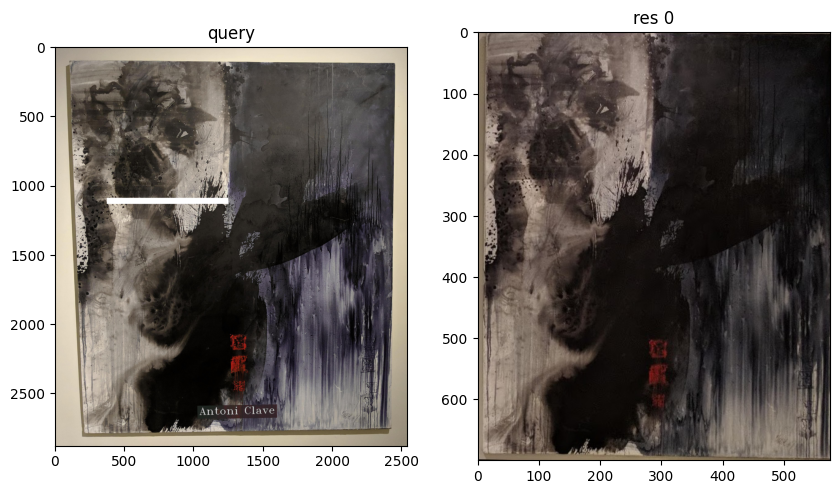

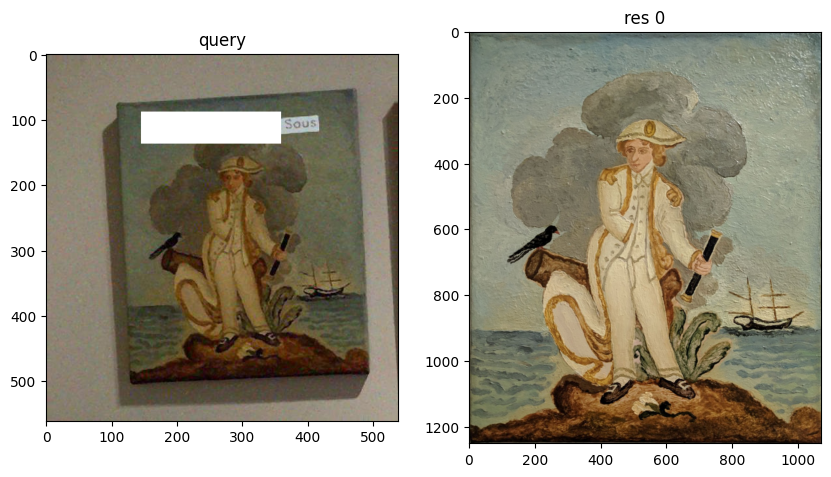

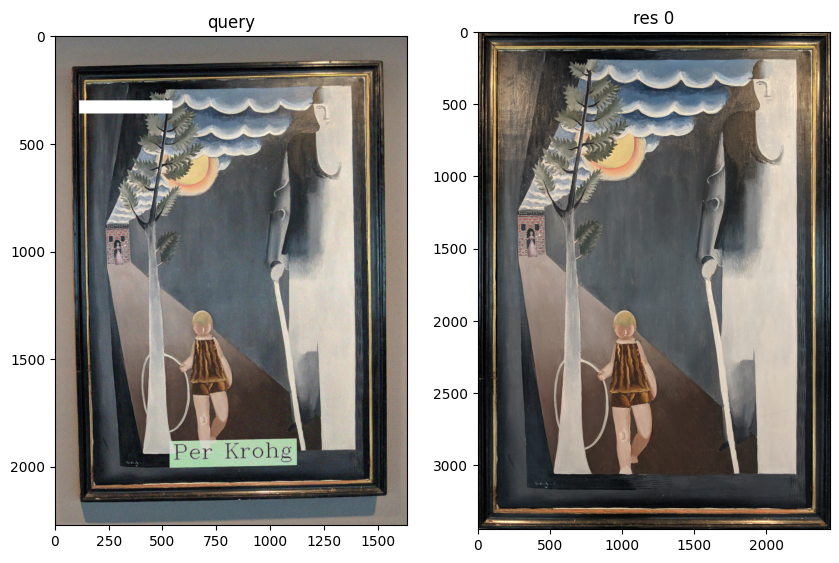

In [68]:
from skimage.io import imread

def plot_image_and_similar_multiple(qs, top_k_qs) -> None:

    for i in range(min(3, len(qs))):
        query = qs[i]

        f, axarr = plt.subplots(1, 1+len(top_k_qs[i]), figsize=(10, 10))
        axarr[0].imshow(query)
        axarr[0].title.set_text("query")
        for j in range(len(top_k_qs[i])):
            res = imread(top_k_qs[i][j][0])
            axarr[1+j].imshow(res)
            axarr[1+j].title.set_text(f"res {j}")
        plt.show()
        
        
plot_image_and_similar_multiple(qsd1_w5, top_5_multiple)

In [69]:
import pandas as pd

prediction = pd.read_pickle('./results/qsd1_w5/4descrip/result_top1.pkl')

print(f"prediction = {prediction}")

print("\n")
gt_corresps = pd.read_pickle('../data/qsd1_w5_denoised/gt_corresps.pkl')

print(f"gt_corresps = {gt_corresps}")

prediction = [[[213]], [[48]], [[260]], [[21]], [[148]], [[53]], [[-1]], [[132], [-1], [69]], [[258]], [[218]], [[157], [212], [133]], [[-1]], [[-1]], [[199]], [[282]], [[44], [241]], [[197]], [[-1]], [[170]], [[183]], [[85]], [[92], [-1], [252]], [[116]], [[255]], [[-1]], [[90], [91], [262]], [[-1]], [[90], [91], [262]], [[35]], [[104]]]


gt_corresps = [[-1], [48], [260], [21], [128], [53], [-1], [132, 237, 69], [258], [218], [157, 212, 133], [-1], [-1], [199], [282], [44, 241], [-1], [-1], [170], [183], [-1], [184, 182, 252], [116], [-1], [-1], [90, 91, 262], [-1], [90, 91, 262], [35], [104]]


# Mean Angular

In [70]:
reload(evaluate)
prediction_angular = pd.read_pickle('../data/morphology_masks_qsd1_w5/frames.pkl')

print(f"prediction = {prediction_angular}")

print("\n")
gt_corresps_angular = pd.read_pickle('../data/qsd1_w5_denoised/frames.pkl')

print(f"gt_corresps = {gt_corresps_angular}")
mean, std, median = evaluate.mean_angular_error(prediction_angular, gt_corresps_angular)
print(f"mean angular: {mean}")
print(f"std angular: {std}")
print(f"median angular: {median}")
    

prediction = [[[0.0, [(76, 95), (76, 2811), (2451, 2811), (2451, 95)]]], [[1.6706532713999678, [(69, 66), (83, 546), (495, 534), (481, 54)]]], [[0.3873146763931162, [(61, 112), (75, 2183), (1544, 2173), (1530, 102)]]], [[2.056279006142952, [(100, 138), (127, 890), (638, 871), (611, 119)]]], [[2.6025622024998065, [(0, 74), (16, 713), (532, 711), (502, 51)]]], [[2.8961369679329563, [(60, 33), (30, 626), (720, 661), (750, 68)]]], [[0.5689808330899387, [(132, 59), (109, 2375), (3746, 2412), (3769, 96)]]], [[0.2808594146833859, [(53, 0), (57, 820), (1002, 816), (998, 0)]], [0.9060620967532051, [(1193, 0), (1180, 810), (1991, 823), (2004, 1)]], [0.2246881796245023, [(2120, 0), (2128, 772), (2820, 765), (2817, 0)]]], [[14.586186068236414, [(144, 219), (284, 758), (699, 650), (559, 112)]]], [[0.8905362533605713, [(84, 60), (102, 1218), (1023, 1204), (1005, 46)]]], [[6.480466020428937, [(110, 113), (53, 606), (365, 642), (421, 149)]], [4.802190090054283, [(614, 219), (584, 587), (844, 609), (87